***
## Table of Contents
<br>
  <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. Oversampling </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">3. Undersampling</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">4.Feature Transformation with feature selection</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">5.Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>

In [50]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
warnings.simplefilter("ignore", DeprecationWarning)
import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics



from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

In [51]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
#     m['Features']=m['Features'].str.replace("dom_function_","")
#     m['Features']=m['Features'].str.replace("js_function_","")
#     m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
#     m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

In [52]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

In [53]:
columns=['http_header_cache-control_set_max-age',
 'http_header_cache-control_set_must-revalidate',
 'http_header_cache-control_set_no-cache',
 'http_header_cache-control_set_no-store',
 'http_header_cache-control_set_private',
 'http_header_cache-control_set_public',
 'http_header_connection_close',
 'http_header_connection_keep-alive',
 'http_header_content-encoding_gzip',
 'http_header_content-language_text/html',
 'http_header_content-length',
 'http_header_expect-ctmax-age',
 'http_header_pragmano-cache',
 'http_header_server_apache',
 'http_header_server_nginx',
 'http_header_strict-transport-security_max-age',
 'http_header_transfer-encoding_chunked',
 'http_header_vary_accept',
 'http_header_vary_age',
 'http_header_via_1.1',
 'http_header_x-cintent-type-options_nosniff',
 'http_header_x-xss-enabled','Target','domain']

In [54]:
df=pd.read_csv('Modified_http.csv',usecols=columns)

df.rename(columns={'Malicious':'Target'},inplace=True)
df.fillna(value=0,inplace=True)

cookies=[columns for columns in df.columns if 'number' in columns]
df.drop(cookies,axis=1,inplace=True)

df=df[df['domain']!=0]

df.sort_values(by='Target',inplace=True,ascending=False)
df.drop_duplicates(['domain'], keep='first',inplace=True)

df=df.sample(frac=1,random_state=0)
df.set_index(['domain'],drop=True,inplace=True)
print("Shape of our dataset:",df.shape)

Shape of our dataset: (45856, 23)


In [55]:
df.Target.value_counts()

0    39835
1     6021
Name: Target, dtype: int64

In [56]:
train=df.iloc[:32100,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

In [57]:
test=df.iloc[32100:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [58]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC'])

In [24]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns[:-2])
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9119003115264798
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25654  2226    27880
True         602  3618     4220
__all__    26256  5844    32100

Accuracy of the model for test data is: 0.9100756033730736
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10981   974    11955
True         263  1538     1801
__all__    11244  2512    13756



Logistic Regression
Accuracy of the model for training data is: 0.8838940809968847
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25471  2409    27880
True        1318  2902     4220
__all__    26789  5311    32100

Accuracy of the model for test data is: 0.8827420761849375
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10929  1026    11955
True         587  1214     1801
__all__    11516  2240    13756



RandomForest Classifier
Accuracy of the model for training data is: 0.9193146417445482
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25699  2181    27880
True         409  3811     4220
__all__    26108  5992    32100

Accuracy of the model for test data is: 0.9089851701075894
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10959   996    11955
True         256  1545     1801
__all__    11215  2541    13756



Adaoost Classifier
Accuracy of the model for training data is: 0.894797507788162
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25644  2236    27880
True        1141  3079     4220
__all__    26785  5315    32100

Accuracy of the model for test data is: 0.8955364931666182
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10999   956    11955
True         481  1320     1801
__all__    11480  2276    13756



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9064485981308411
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25672  2208    27880
True         795  3425     4220
__all__    26467  5633    32100

Accuracy of the model for test data is: 0.9055684792090724
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11003   952    11955
True         347  1454     1801
__all__    11350  2406    13756



ExtraTree Classifier
Accuracy of the model for training data is: 0.9210903426791277
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25729  2151    27880
True         382  3838     4220
__all__    26111  5989    32100

Accuracy of the model for test data is: 0.9088397790055248
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10948  1007    11955
True         247  1554     1801
__all__    11195  2561    13756



Bagging Classifier
Accuracy of the model for training data is: 0.9194080996884735
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25713  2167    27880
True         420  3800     4220
__all__    26133  5967    32100

Accuracy of the model for test data is: 0.9097121256179121
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10972   983    11955
True         259  1542     1801
__all__    11231  2525    13756



Neural Network-1
The accuracy of the model on training data is: 0.8986292834890965


Predicted  False  True  __all__
Actual                         
False      27575   305    27880
True        2949  1271     4220
__all__    30524  1576    32100

The accuracy of the model on test data is: 0.8993166618202966


Predicted  False  True  __all__
Actual                         
False      11843   112    11955
True        1273   528     1801
__all__    13116   640    13756

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [25]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [26]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.911900,3618.0,25654.0,2226.0,602.0,0.079842,0.142654
LogisticRegression,0.883894,2902.0,25471.0,2409.0,1318.0,0.086406,0.312322
RandomForestClassifier,0.919315,3811.0,25699.0,2181.0,409.0,0.078228,0.096919
AdaBoostClassifier,0.894798,3079.0,25644.0,2236.0,1141.0,0.080201,0.270379
GradientBoostingClassifier,0.906449,3425.0,25672.0,2208.0,795.0,0.079197,0.188389
ExtraTreeClassifier,0.921090,3838.0,25729.0,2151.0,382.0,0.077152,0.090521
BaggingClassifier,0.919408,3800.0,25713.0,2167.0,420.0,0.077726,0.099526
Neural Network-1,0.898629,1271.0,27575.0,305.0,2949.0,0.010940,0.698815


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC
index,,,,,,,,,
KNeighborsClassifier,0.910076,1538.0,10981.0,974.0,263.0,0.081472,0.146030,0.886249,0.674464
LogisticRegression,0.882742,1214.0,10929.0,1026.0,587.0,0.085822,0.325930,0.794124,0.537424
RandomForestClassifier,0.908985,1545.0,10959.0,996.0,256.0,0.083312,0.142143,0.887272,0.673249
AdaBoostClassifier,0.895536,1320.0,10999.0,956.0,481.0,0.079967,0.267074,0.826480,0.592735
GradientBoostingClassifier,0.905568,1454.0,11003.0,952.0,347.0,0.079632,0.192671,0.863849,0.646155
ExtraTreeClassifier,0.908840,1554.0,10948.0,1007.0,247.0,0.084233,0.137146,0.889311,0.674747
BaggingClassifier,0.909712,1542.0,10972.0,983.0,259.0,0.082225,0.143809,0.886983,0.674394
Neural Network-1,0.899317,528.0,11843.0,112.0,1273.0,0.009368,0.706830,0.886983,0.454524


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [27]:
feat_impt_plot(np.average(feat_imp,axis=0),columns[:-2])

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [28]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

In [29]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [30]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns[:-2])
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.911316355810617
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25288   2592    27880
True        2353  25527    27880
__all__    27641  28119    55760

Accuracy of the model for test data is: 0.8969177086362314
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10765  1190    11955
True         228  1573     1801
__all__    10993  2763    13756



Logistic Regression
Accuracy of the model for training data is: 0.8664454806312769
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23090   4790    27880
True        2657  25223    27880
__all__    25747  30013    55760

Accuracy of the model for test data is: 0.8423960453620238
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9971  1984    11955
True         184  1617     1801
__all__    10155  3601    13756



RandomForest Classifier
Accuracy of the model for training data is: 0.9329626972740316
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24951   2929    27880
True         809  27071    27880
__all__    25760  30000    55760

Accuracy of the model for test data is: 0.88601337598139
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10532  1423    11955
True         145  1656     1801
__all__    10677  3079    13756



Adaoost Classifier
Accuracy of the model for training data is: 0.8738163558106169
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23517   4363    27880
True        2673  25207    27880
__all__    26190  29570    55760

Accuracy of the model for test data is: 0.8507560337307357
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10101  1854    11955
True         199  1602     1801
__all__    10300  3456    13756



GradientBoosting Classifier
Accuracy of the model for training data is: 0.8951398852223816
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24400   3480    27880
True        2367  25513    27880
__all__    26767  28993    55760

Accuracy of the model for test data is: 0.8801977318988078
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10493  1462    11955
True         186  1615     1801
__all__    10679  3077    13756



ExtraTree Classifier
Accuracy of the model for training data is: 0.9352941176470588
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25002   2878    27880
True         730  27150    27880
__all__    25732  30028    55760

Accuracy of the model for test data is: 0.8846321605117767
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10516  1439    11955
True         148  1653     1801
__all__    10664  3092    13756



Bagging Classifier
Accuracy of the model for training data is: 0.9329088952654232
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24962   2918    27880
True         823  27057    27880
__all__    25785  29975    55760

Accuracy of the model for test data is: 0.8854318115731318
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10518  1437    11955
True         139  1662     1801
__all__    10657  3099    13756



Neural Network-1
The accuracy of the model on training data is: 0.9097560975609756


Predicted  False   True  __all__
Actual                          
False      24013   3867    27880
True        1165  26715    27880
__all__    25178  30582    55760

The accuracy of the model on test data is: 0.8711107880197732


Predicted  False  True  __all__
Actual                         
False      10317  1638    11955
True         135  1666     1801
__all__    10452  3304    13756

### <a id='2.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [31]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [32]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.911316,25527.0,25288.0,2592.0,2353.0,0.092970,0.084397
LogisticRegression,0.866445,25223.0,23090.0,4790.0,2657.0,0.171808,0.095301
RandomForestClassifier,0.932963,27071.0,24951.0,2929.0,809.0,0.105057,0.029017
AdaBoostClassifier,0.873816,25207.0,23517.0,4363.0,2673.0,0.156492,0.095875
GradientBoostingClassifier,0.895140,25513.0,24400.0,3480.0,2367.0,0.124821,0.084900
ExtraTreeClassifier,0.935294,27150.0,25002.0,2878.0,730.0,0.103228,0.026184
BaggingClassifier,0.932909,27057.0,24962.0,2918.0,823.0,0.104663,0.029519
Neural Network-1,0.909756,26715.0,24013.0,3867.0,1165.0,0.138702,0.041786


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.896918,1573.0,10765.0,1190.0,228.0,0.099540,0.126596,0.886932,0.651550
LogisticRegression,0.842396,1617.0,9971.0,1984.0,184.0,0.165956,0.102165,0.865939,0.561590
RandomForestClassifier,0.886013,1656.0,10532.0,1423.0,145.0,0.119030,0.080511,0.900230,0.647801
AdaBoostClassifier,0.850756,1602.0,10101.0,1854.0,199.0,0.155082,0.110494,0.867212,0.571180
GradientBoostingClassifier,0.880198,1615.0,10493.0,1462.0,186.0,0.122292,0.103276,0.887216,0.626882
ExtraTreeClassifier,0.884632,1653.0,10516.0,1439.0,148.0,0.120368,0.082177,0.898728,0.644404
BaggingClassifier,0.885432,1662.0,10518.0,1437.0,139.0,0.120201,0.077179,0.901310,0.648057
Neural Network-1,0.871111,1666.0,10317.0,1638.0,135.0,0.137014,0.074958,0.901310,0.622234


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [37]:
feat_impt_plot(np.average(feat_imp,axis=0),columns[:-2])

### <a id='3' style="text-decoration : none; color : #000000;"> 3. Undersampling</a>

In [33]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns[:-2]]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)


Shape after undersampling (8440, 22)


In [34]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [35]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns[:-2])
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.8917061611374407
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3832   388     4220
True         526  3694     4220
__all__     4358  4082     8440

Accuracy of the model for test data is: 0.8867403314917127
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10647  1308    11955
True         250  1551     1801
__all__    10897  2859    13756



Logistic Regression
Accuracy of the model for training data is: 0.8670616113744076
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3515   705     4220
True         417  3803     4220
__all__     3932  4508     8440

Accuracy of the model for test data is: 0.8398517010758941
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9936  2019    11955
True         184  1617     1801
__all__    10120  3636    13756



RandomForest Classifier
Accuracy of the model for training data is: 0.9273696682464455
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3779   441     4220
True         172  4048     4220
__all__     3951  4489     8440

Accuracy of the model for test data is: 0.8756179121837744
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10382  1573    11955
True         138  1663     1801
__all__    10520  3236    13756



Adaoost Classifier
Accuracy of the model for training data is: 0.8696682464454977
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3555   665     4220
True         435  3785     4220
__all__     3990  4450     8440

Accuracy of the model for test data is: 0.8466850828729282
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10039  1916    11955
True         193  1608     1801
__all__    10232  3524    13756



GradientBoosting Classifier
Accuracy of the model for training data is: 0.8901658767772512
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3716   504     4220
True         423  3797     4220
__all__     4139  4301     8440

Accuracy of the model for test data is: 0.8758359988368711
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10433  1522    11955
True         186  1615     1801
__all__    10619  3137    13756



ExtraTree Classifier
Accuracy of the model for training data is: 0.9304502369668246
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3792   428     4220
True         159  4061     4220
__all__     3951  4489     8440

Accuracy of the model for test data is: 0.8733643501017738
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10347  1608    11955
True         134  1667     1801
__all__    10481  3275    13756



Bagging Classifier
Accuracy of the model for training data is: 0.9265402843601895
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3782   438     4220
True         182  4038     4220
__all__     3964  4476     8440

Accuracy of the model for test data is: 0.8715469613259669
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10325  1630    11955
True         137  1664     1801
__all__    10462  3294    13756



Neural Network-1
The accuracy of the model on training data is: 0.9053317534980051


Predicted  False  True  __all__
Actual                         
False       3686   534     4220
True         265  3955     4220
__all__     3951  4489     8440

The accuracy of the model on test data is: 0.8701657458563536


Predicted  False  True  __all__
Actual                         
False      10306  1649    11955
True         137  1664     1801
__all__    10443  3313    13756

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [36]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [37]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.891706,3694.0,3832.0,388.0,526.0,0.091943,0.124645
LogisticRegression,0.867062,3803.0,3515.0,705.0,417.0,0.167062,0.098815
RandomForestClassifier,0.927370,4048.0,3779.0,441.0,172.0,0.104502,0.040758
AdaBoostClassifier,0.869668,3785.0,3555.0,665.0,435.0,0.157583,0.103081
GradientBoostingClassifier,0.890166,3797.0,3716.0,504.0,423.0,0.119431,0.100237
ExtraTreeClassifier,0.930450,4061.0,3792.0,428.0,159.0,0.101422,0.037678
BaggingClassifier,0.926540,4038.0,3782.0,438.0,182.0,0.103791,0.043128
Neural Network-1,0.905332,3955.0,3686.0,534.0,265.0,0.126540,0.062796


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.886740,1551.0,10647.0,1308.0,250.0,0.109410,0.138812,0.875889,0.624972
LogisticRegression,0.839852,1617.0,9936.0,2019.0,184.0,0.168883,0.102165,0.864476,0.557607
RandomForestClassifier,0.875618,1663.0,10382.0,1573.0,138.0,0.131577,0.076624,0.895900,0.629701
AdaBoostClassifier,0.846685,1608.0,10039.0,1916.0,193.0,0.160268,0.107163,0.866285,0.566086
GradientBoostingClassifier,0.875836,1615.0,10433.0,1522.0,186.0,0.127311,0.103276,0.884707,0.618575
ExtraTreeClassifier,0.873364,1667.0,10347.0,1608.0,134.0,0.134504,0.074403,0.895546,0.626544
BaggingClassifier,0.871547,1664.0,10325.0,1630.0,137.0,0.136345,0.076069,0.893793,0.622531
Neural Network-1,0.870166,1664.0,10306.0,1649.0,137.0,0.137934,0.076069,0.893793,0.620054


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [38]:
feat_impt_plot(np.average(feat_imp,axis=0),columns[:-2])

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [59]:
df.reset_index(inplace=True)
columns.remove('Target')
df_min=df[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 946 features
EntitySet scattered to workers in 4.439 seconds
Elapsed: 00:03 | Remaining: 00:33 | Progress:   9%|▉         | Calculated: 1/11 chunks

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.exception() is not None:
concurrent.futures._base.CancelledError


Elapsed: 00:04 | Remaining: 00:23 | Progress:  18%|█▊        | Calculated: 2/11 chunks

Exception ignored in: <bound method Client.__del__ of <Client: not connected>>
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1075, in __del__
    self.close()
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1290, in close
    sync(self.loop, self._close, fast=True)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 331, in sync
    six.reraise(*error[0])
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/six.py", line 693, in reraise
    raise value
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 316, in f
    result[0] = yield future
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 729, in run
    value = future.result()
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yi

Elapsed: 00:05 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [60]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

distributed.core - INFO - Event loop was unresponsive in Nanny for 3.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.33s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 4.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.55s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

In [61]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [62]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [63]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [64]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [65]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [66]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [67]:
columns=feature_selection_df[feature_selection_df.Total>=3]['Feature'].values

In [69]:
fs=fs.reindex(df.index.values)
train=fs.iloc[:32100]
train_Y=train.Target.values
train_X=train[columns].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[32100:]
test_Y=test.Target.values
test_X=test[columns]

scaled_X_test=scaler.transform(test_X)

In [70]:
print('Features we will be using:\n')
display(columns)

Features we will be using:



array(['http_header_content-language_text/html + http_header_transfer-encoding_chunked',
       'http_header_vary_age / http_header_content-length',
       'http_header_vary_accept / http_header_content-language_text/html',
       'http_header_vary_accept + http_header_via_1.1',
       'http_header_transfer-encoding_chunked + http_header_x-xss-enabled',
       'http_header_transfer-encoding_chunked + http_header_vary_accept',
       'http_header_server_nginx + http_header_transfer-encoding_chunked',
       'http_header_content-language_text/html / http_header_transfer-encoding_chunked',
       'http_header_content-language_text/html / http_header_connection_keep-alive',
       'http_header_content-language_text/html + http_header_via_1.1',
       'http_header_content-language_text/html + http_header_vary_accept',
       'http_header_content-language_text/html + http_header_server_nginx',
       'http_header_content-language_text/html + http_header_expect-ctmax-age',
       'http_header

In [71]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [72]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.8777570093457944
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27505   375    27880
True        3549   671     4220
__all__    31054  1046    32100

Accuracy of the model for test data is: 0.8814335562663564
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11824   131    11955
True        1500   301     1801
__all__    13324   432    13756



Logistic Regression
Accuracy of the model for training data is: 0.8808411214953271
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25727  2153    27880
True        1672  2548     4220
__all__    27399  4701    32100

Accuracy of the model for test data is: 0.8782349520209363
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11025   930    11955
True         745  1056     1801
__all__    11770  1986    13756



RandomForest Classifier
Accuracy of the model for training data is: 0.8974766355140187
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25332  2548    27880
True         743  3477     4220
__all__    26075  6025    32100

Accuracy of the model for test data is: 0.897862750799651
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10881  1074    11955
True         331  1470     1801
__all__    11212  2544    13756



Adaoost Classifier
Accuracy of the model for training data is: 0.8805607476635514
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25714  2166    27880
True        1668  2552     4220
__all__    27382  4718    32100

Accuracy of the model for test data is: 0.8777987787147427
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11015   940    11955
True         741  1060     1801
__all__    11756  2000    13756



GradientBoosting Classifier
Accuracy of the model for training data is: 0.8945482866043614
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25339  2541    27880
True         844  3376     4220
__all__    26183  5917    32100

Accuracy of the model for test data is: 0.894446059901134
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10881  1074    11955
True         378  1423     1801
__all__    11259  2497    13756

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.exception() is not None:
concurrent.futures._base.CancelledError
Exception ignored in: <bound method



ExtraTree Classifier
Accuracy of the model for training data is: 0.8978193146417446
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25334  2546    27880
True         734  3486     4220
__all__    26068  6032    32100

Accuracy of the model for test data is: 0.8975719685955219
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10875  1080    11955
True         329  1472     1801
__all__    11204  2552    13756



Bagging Classifier
Accuracy of the model for training data is: 0.8975700934579439
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25331  2549    27880
True         739  3481     4220
__all__    26070  6030    32100

Accuracy of the model for test data is: 0.8977173596975865
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10878  1077    11955
True         330  1471     1801
__all__    11208  2548    13756



Neural Network-1
The accuracy of the model on training data is: 0.890373831775701


Predicted  False  True  __all__
Actual                         
False      25322  2558    27880
True         961  3259     4220
__all__    26283  5817    32100

The accuracy of the model on test data is: 0.8924832800232626


Predicted  False  True  __all__
Actual                         
False      10884  1071    11955
True         408  1393     1801
__all__    11292  2464    13756

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [73]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [74]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.877757,671.0,27505.0,375.0,3549.0,0.013451,0.840995
LogisticRegression,0.880841,2548.0,25727.0,2153.0,1672.0,0.077224,0.396209
RandomForestClassifier,0.897477,3477.0,25332.0,2548.0,743.0,0.091392,0.176066
AdaBoostClassifier,0.880561,2552.0,25714.0,2166.0,1668.0,0.077690,0.395261
GradientBoostingClassifier,0.894548,3376.0,25339.0,2541.0,844.0,0.091141,0.200000
ExtraTreeClassifier,0.897819,3486.0,25334.0,2546.0,734.0,0.091320,0.173934
BaggingClassifier,0.897570,3481.0,25331.0,2549.0,739.0,0.091428,0.175118
Neural Network-1,0.890374,3259.0,25322.0,2558.0,961.0,0.091750,0.227725


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.881434,301.0,11824.0,131.0,1500.0,0.010958,0.832871,0.578086,0.302047
LogisticRegression,0.878235,1056.0,11025.0,930.0,745.0,0.077792,0.413659,0.754275,0.488075
RandomForestClassifier,0.897863,1470.0,10881.0,1074.0,331.0,0.089837,0.183787,0.863188,0.631093
AdaBoostClassifier,0.877799,1060.0,11015.0,940.0,741.0,0.078628,0.411438,0.754967,0.487978
GradientBoostingClassifier,0.894446,1423.0,10881.0,1074.0,378.0,0.089837,0.209883,0.850140,0.612836
ExtraTreeClassifier,0.897572,1472.0,10875.0,1080.0,329.0,0.090339,0.182676,0.863492,0.630856
BaggingClassifier,0.897717,1471.0,10878.0,1077.0,330.0,0.090088,0.183232,0.863340,0.630974
Neural Network-1,0.892483,1393.0,10884.0,1071.0,408.0,0.089586,0.226541,0.863340,0.601591


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [75]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

In [76]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

distributed.core - INFO - Event loop was unresponsive in Nanny for 5.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

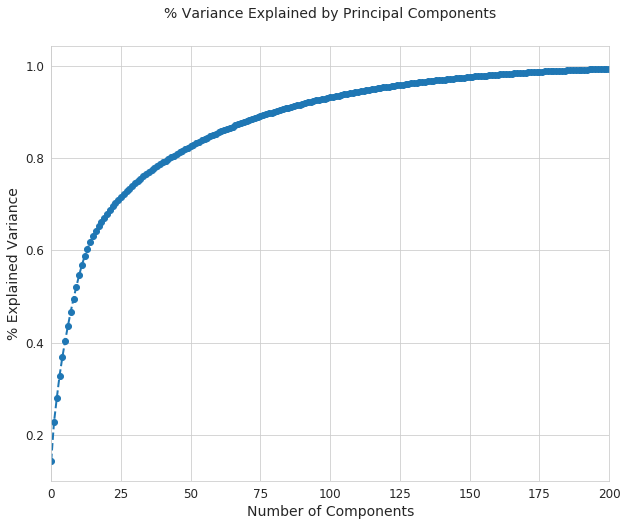

In [78]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [79]:
pca=PCA(n_components=100,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 100 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 100 components is: 0.9295353936069971


In [80]:
X_train=X_pca_21[:32100]
Y_train=fs.iloc[:32100]['Target'].values
X_test=X_pca_21[32100:]
Y_test=fs.iloc[32100:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [83]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,100).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9028660436137071
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27752   128    27880
True        2990  1230     4220
__all__    30742  1358    32100

Accuracy of the model for test data is: 0.9023698749636522
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11880    75    11955
True        1268   533     1801
__all__    13148   608    13756



Logistic Regression
Accuracy of the model for training data is: 0.8996573208722741
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25499  2381    27880
True         840  3380     4220
__all__    26339  5761    32100

Accuracy of the model for test data is: 0.8989531840651352
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10944  1011    11955
True         379  1422     1801
__all__    11323  2433    13756



RandomForest Classifier
Accuracy of the model for training data is: 0.9196884735202492
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25708  2172    27880
True         406  3814     4220
__all__    26114  5986    32100

Accuracy of the model for test data is: 0.9086216923524281
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10956   999    11955
True         258  1543     1801
__all__    11214  2542    13756



Adaoost Classifier
Accuracy of the model for training data is: 0.905202492211838
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25600  2280    27880
True         763  3457     4220
__all__    26363  5737    32100

Accuracy of the model for test data is: 0.904405350392556
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10974   981    11955
True         334  1467     1801
__all__    11308  2448    13756



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9114018691588786
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25690  2190    27880
True         654  3566     4220
__all__    26344  5756    32100

Accuracy of the model for test data is: 0.9093486478627508
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      11003   952    11955
True         295  1506     1801
__all__    11298  2458    13756



ExtraTree Classifier
Accuracy of the model for training data is: 0.9210903426791277
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25729  2151    27880
True         382  3838     4220
__all__    26111  5989    32100

Accuracy of the model for test data is: 0.9084036056993312
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10947  1008    11955
True         252  1549     1801
__all__    11199  2557    13756



Bagging Classifier
Accuracy of the model for training data is: 0.9190654205607477
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25703  2177    27880
True         421  3799     4220
__all__    26124  5976    32100

Accuracy of the model for test data is: 0.909930212271009
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10966   989    11955
True         250  1551     1801
__all__    11216  2540    13756



Neural Network-1
The accuracy of the model on training data is: 0.9097196261682243


Predicted  False  True  __all__
Actual                         
False      25609  2271    27880
True         627  3593     4220
__all__    26236  5864    32100

The accuracy of the model on test data is: 0.9076039546379762


Predicted  False  True  __all__
Actual                         
False      10976   979    11955
True         292  1509     1801
__all__    11268  2488    13756

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [84]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [85]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.902866,1230.0,27752.0,128.0,2990.0,0.004591,0.708531
LogisticRegression,0.899657,3380.0,25499.0,2381.0,840.0,0.085402,0.199052
RandomForestClassifier,0.919688,3814.0,25708.0,2172.0,406.0,0.077905,0.096209
AdaBoostClassifier,0.905202,3457.0,25600.0,2280.0,763.0,0.081779,0.180806
GradientBoostingClassifier,0.911402,3566.0,25690.0,2190.0,654.0,0.078551,0.154976
ExtraTreeClassifier,0.921090,3838.0,25729.0,2151.0,382.0,0.077152,0.090521
BaggingClassifier,0.919065,3799.0,25703.0,2177.0,421.0,0.078085,0.099763
Neural Network-1,0.909720,3593.0,25609.0,2271.0,627.0,0.081456,0.148578


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.902370,533.0,11880.0,75.0,1268.0,0.006274,0.704053,0.644837,0.475399
LogisticRegression,0.898953,1422.0,10944.0,1011.0,379.0,0.084567,0.210439,0.852497,0.623254
RandomForestClassifier,0.908622,1543.0,10956.0,999.0,258.0,0.083563,0.143254,0.886591,0.671964
AdaBoostClassifier,0.904405,1467.0,10974.0,981.0,334.0,0.082058,0.185453,0.866245,0.646003
GradientBoostingClassifier,0.909349,1506.0,11003.0,952.0,295.0,0.079632,0.163798,0.878285,0.666176
ExtraTreeClassifier,0.908404,1549.0,10947.0,1008.0,252.0,0.084316,0.139922,0.887881,0.672674
BaggingClassifier,0.909930,1551.0,10966.0,989.0,250.0,0.082727,0.138812,0.889231,0.676757
Neural Network-1,0.907604,1509.0,10976.0,979.0,292.0,0.081890,0.162132,0.889231,0.662509


In [86]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')